In [15]:
library("knitr") #probably already installed
library("rmarkdown") #probably already installed
library("ggplot2") #plotting with ggplot
#library("ggfortify")
library("leaps")
#library("glmnet")
library("tree")
#library("caret")
#library("randomForest")
library("readr")
library("e1071")
#library("dplyr")
library("gbm")

In [16]:
library(knitr)
knitr::opts_chunk$set(echo = TRUE, tidy=TRUE, message=FALSE, warning=FALSE, strip.white=TRUE, prompt=FALSE,
                      cache=TRUE, size="scriptsize", fig.width=4, fig.height=3, fig.align="center")

### 2a)  
(i) TRUE  
(ii) TRUE, As $\lambda$ grows, the spline becomes less sensitive to the data, with lower
variance to its predictions but more bias.  
(iii) FALSE, they are differentiable up to order M-2 also at the knots.  
(iv) FALSE, there are 7 basis functions  
### 2b)
$X, X^2, X^3, (X - q_1)^3_+, (X - q_2)^3_+$  
### 2c)

In [17]:
id <- "1iI6YaqgG0QJW5onZ_GTBsCvpKPExF30G" # google file ID
catdat <- read.csv(sprintf("https://docs.google.com/uc?id=%s&export=download", id), header=T)

[1] 1369.997


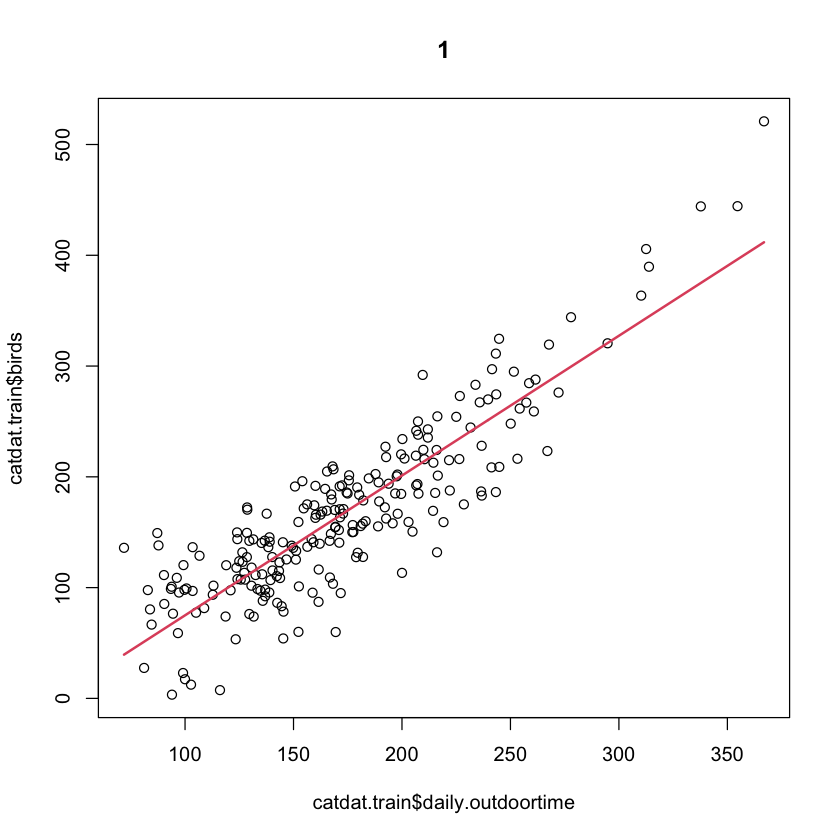

[1] 1199.202


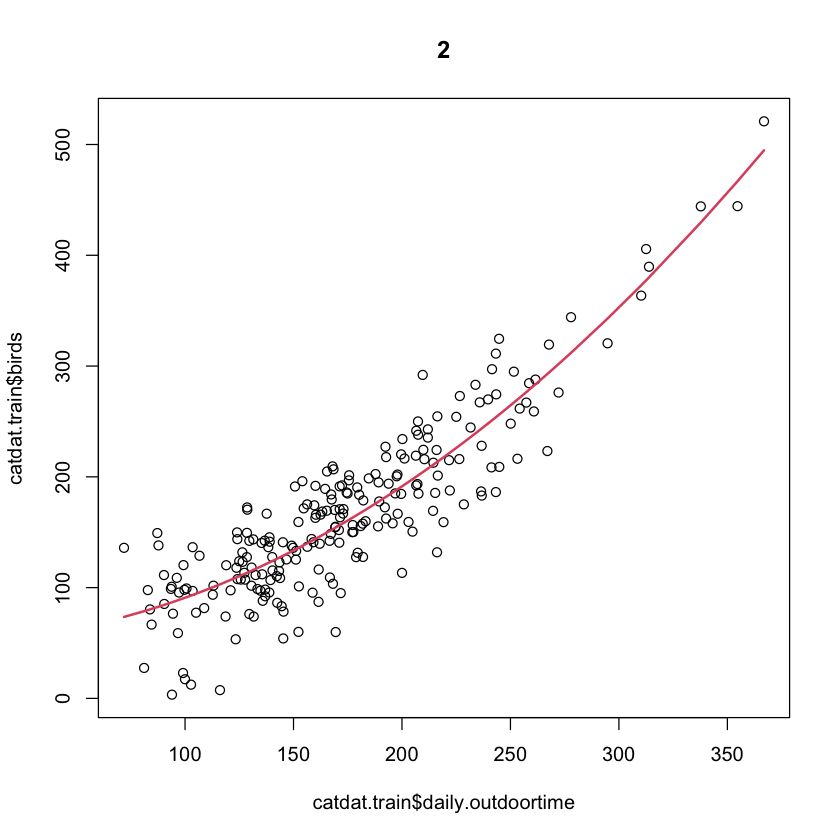

[1] 1198.499


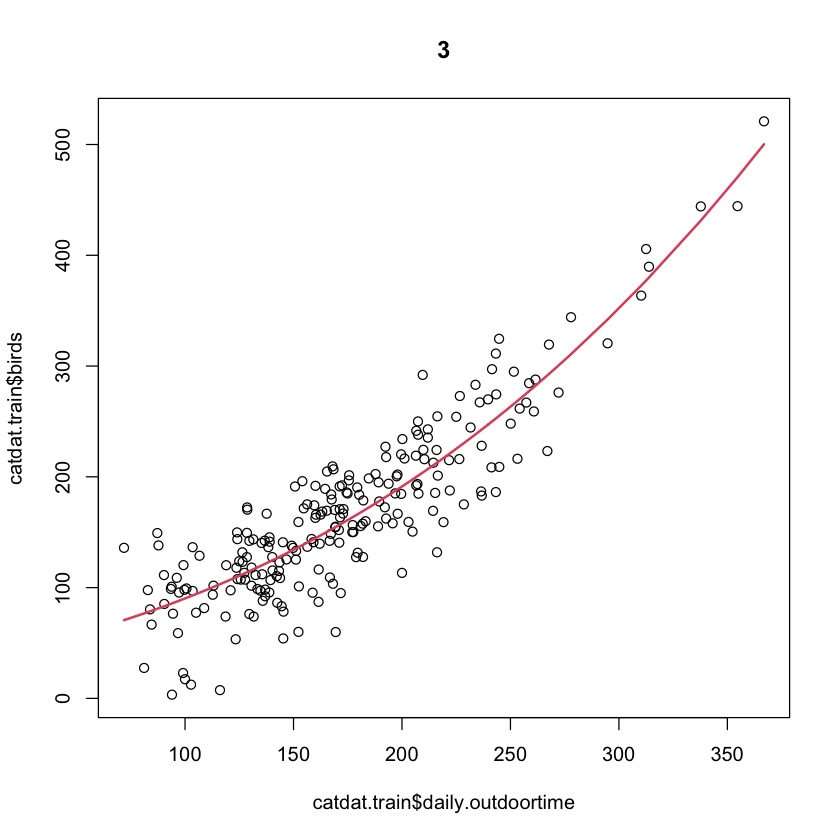

[1] 1188.227


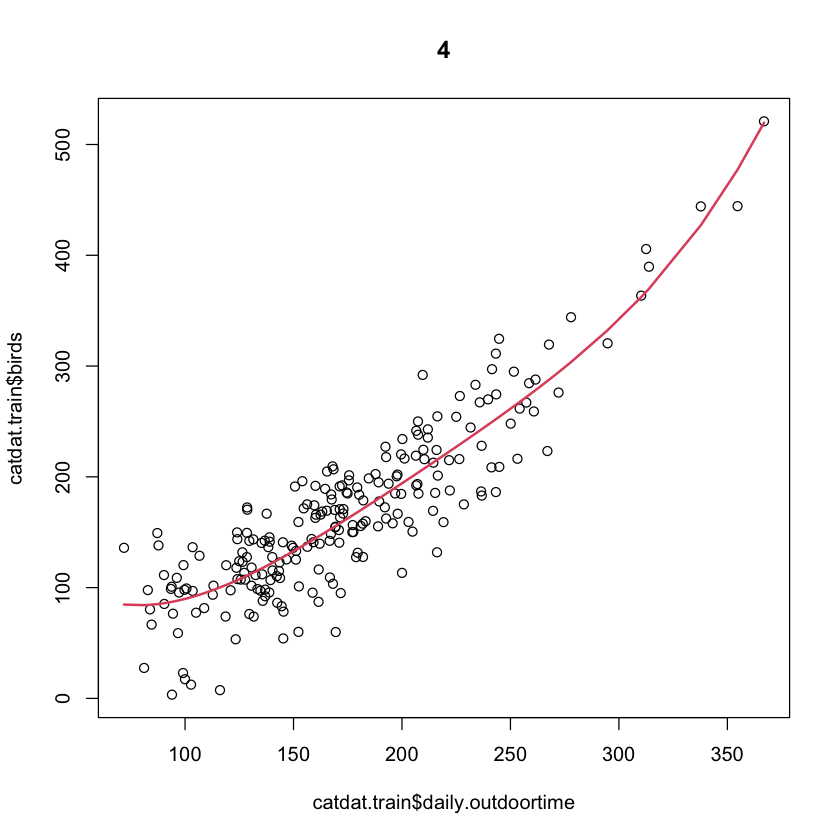

[1] 1175.981


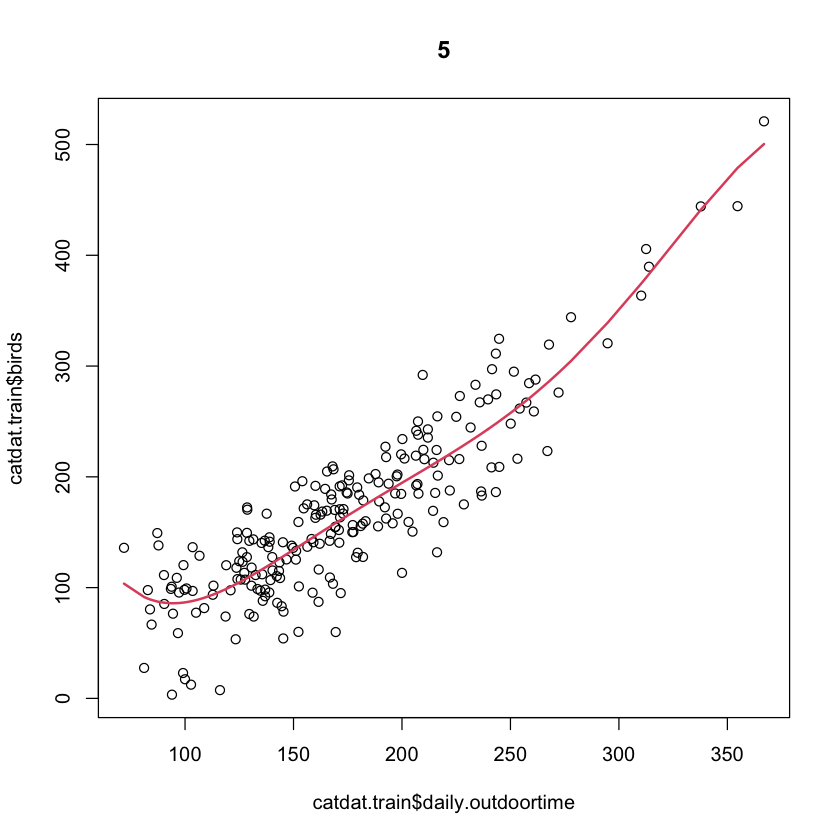

[1] 1173.485


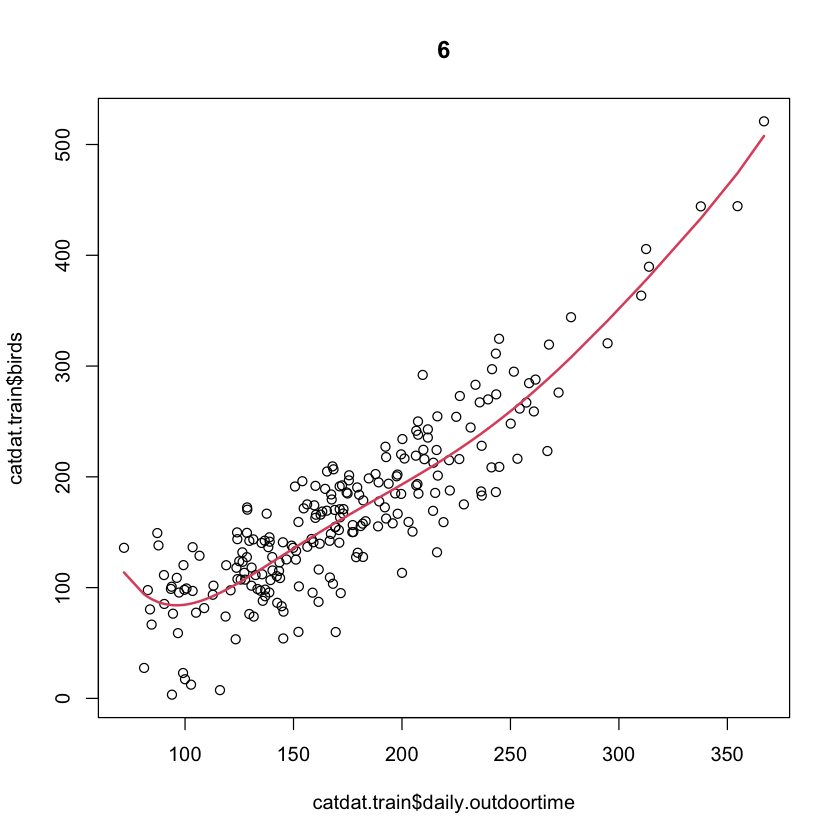

[1] 1173.437


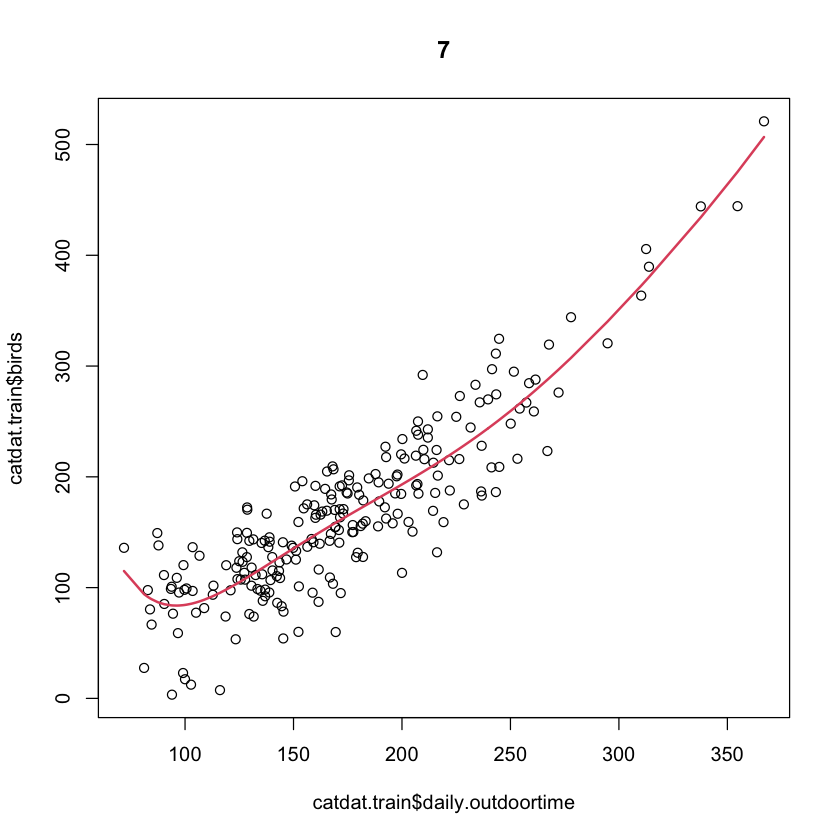

[1] 1166.437


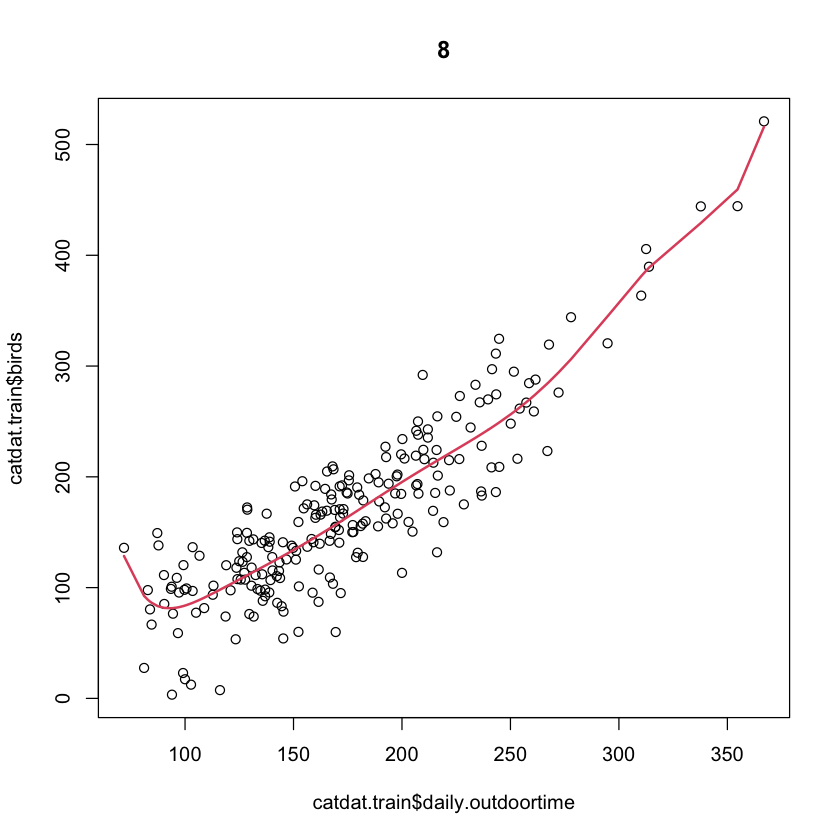

[1] 1166.019


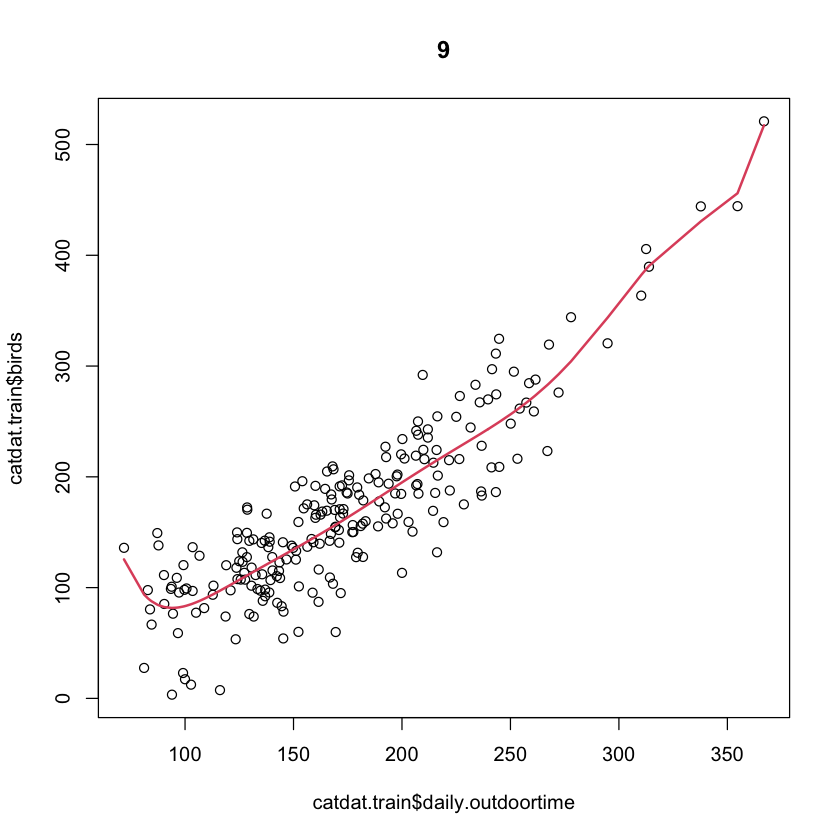

[1] 1164.368


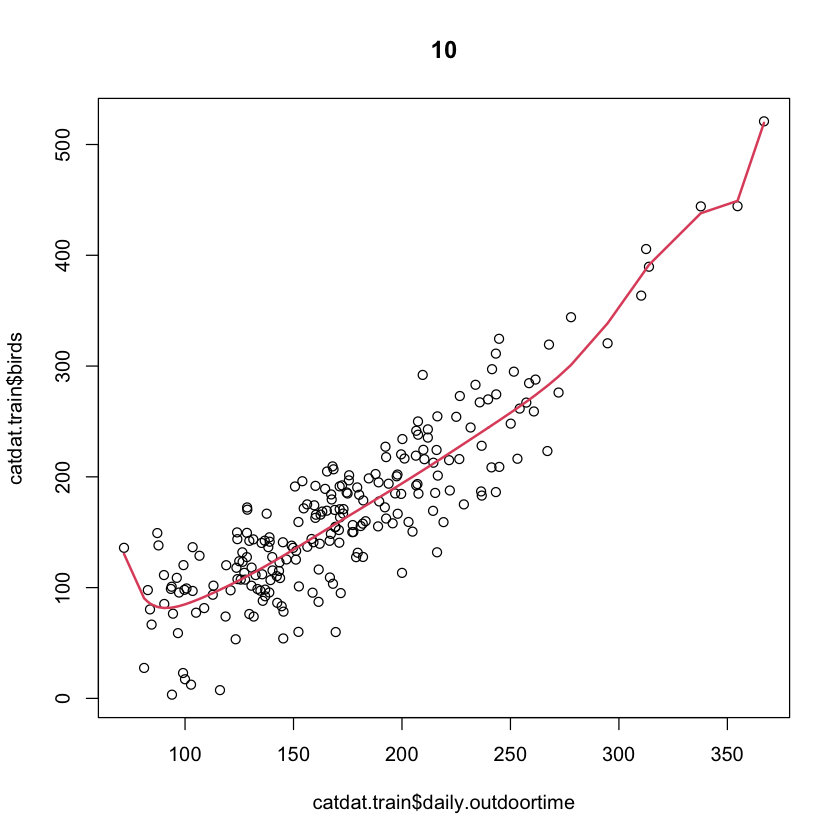

In [18]:
set.seed(4268)

train.ind = sample(1:nrow(catdat), 0.5*nrow(catdat))
catdat.train = catdat[train.ind,]
catdat.test = catdat[-train.ind,]

x <- catdat.train$daily.outdoortime
y <- catdat.train$birds
rmses <- c()

for(d in 1:10) {
    fit <- lm(catdat.train$birds ~ poly(catdat.train$daily.outdoortime, d))
    pred <- predict(fit)

    ix <- sort(x, index.return=T)$ix
    plot(x = catdat.train$daily.outdoortime, y = catdat.train$birds, main=d)
    lines(x[ix], pred[ix], col=2, lwd=2)
    
    print(mean(fit$residuals^2))
    rmses <- c(rmses, mean(fit$residuals^2))
}

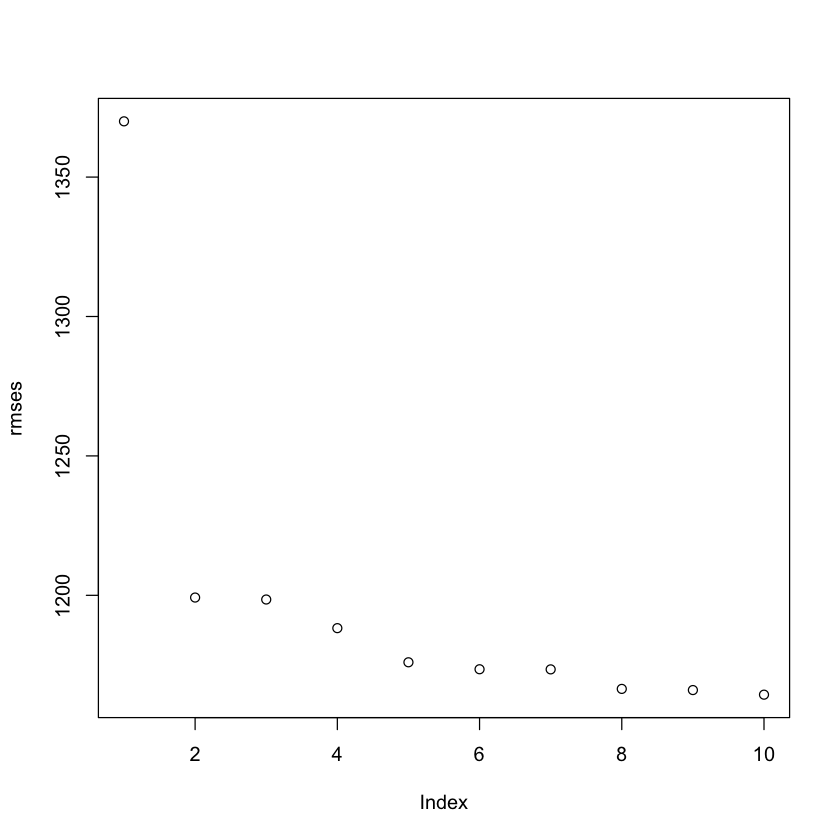

In [19]:
plot(rmses)

(ii) The train RMSE value decreases when the order of the polynomial increases. We get high variance and low bias, also called overfitting.

# Problem 3
## a) 
TRUE, TRUE, FALSE, FALSE

## b)

The leaves remaining when pruning down to 3 leaves would be, 1,5 and 6. In other word the internal nodes left would be "age < 81.5" and "country: ...". This is due to age being the more important predictor, and the split on "age < 46.5" would prove to be less significant than the geographical split, which shows large difference in mortality between France and the east-asian countries..

## c)
### i)

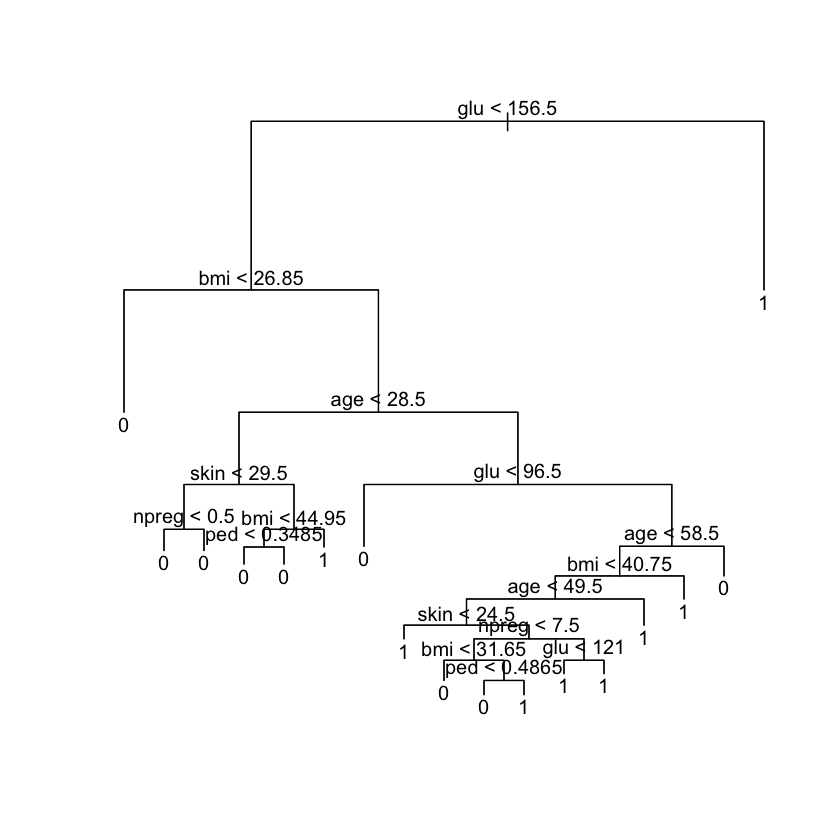

$size
[1] 17 14 10  6  2  1

$dev
[1]  77  78  85  81  82 100

$k
[1]  -Inf  0.00  1.50  2.75  5.00 29.00

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

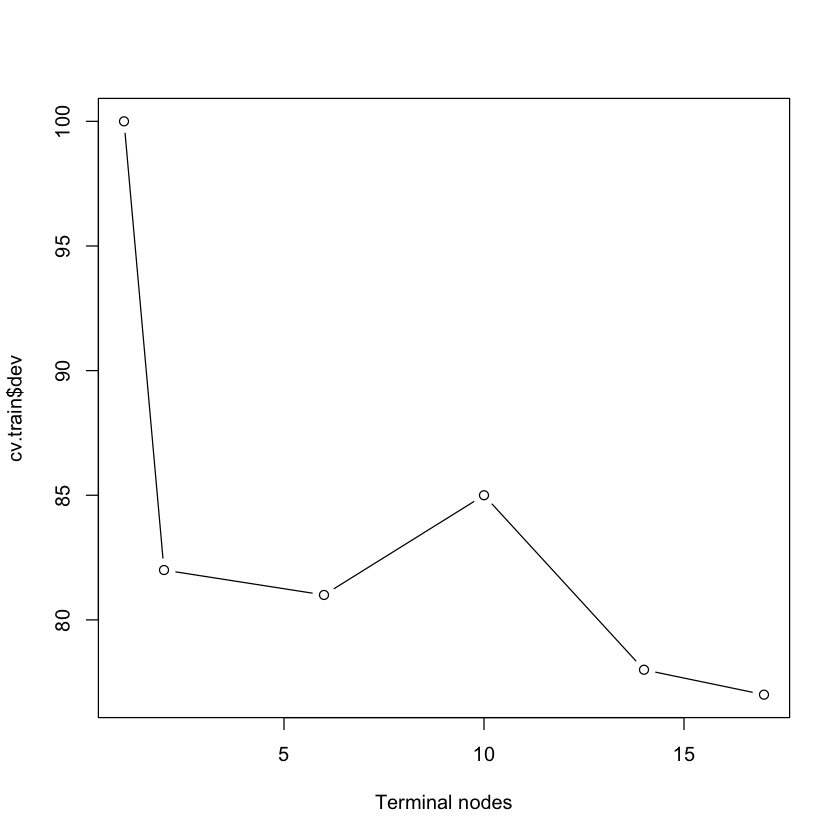

In [20]:

id <- "1Fv6xwKLSZHldRAC1MrcK2mzdOYnbgv0E" # google file ID
d.diabetes <- dget(sprintf("https://docs.google.com/uc?id=%s&export=download", id))
d.train=d.diabetes$ctrain
d.test=d.diabetes$ctest
set.seed(1)
library(tree)

# Creating a simple tree with the training set with default parameters
d.train$diabetes = as.factor(d.train$diabetes) 
ct.train <- tree(diabetes ~ npreg + glu + bp + skin + bmi + ped + age,data=d.train)
plot(ct.train)
text(ct.train)

# Applying cost complexity pruning optimized for low missclassification error

set.seed(1)
cv.train = cv.tree(ct.train, K = 10, FUN = prune.misclass)
plot(cv.train$size,cv.train$dev,type="b",
                   xlab="Terminal nodes")
cv.train


In [21]:
# Using the confusion matrix to calculate the missclassification error
tree.pred = predict(ct.train ,d.test ,type="class")
confMat <- table(tree.pred ,d.test$diabetes)
confMat
1-sum(diag(confMat))/(sum(confMat[1:2,1:2]))

         
tree.pred   0   1
        0 126  28
        1  29  49

[1] 0.2456897

Here we observe that the tree already has the lowest missclassification error $: 24.6\%$ at $17$ terminal nodes,
so there is no need to prune the tree.

### ii)
We will use the tree based method "random forest", as this solves the high variance and non-robustness problems which other prediction models suffer from.

In [22]:
library(randomForest)
set.seed(1)

rf.dtrain = randomForest(diabetes ~. , data=d.train, mtry=4, importance=TRUE, ntree=500)
rf.dtrain




Call:
 randomForest(formula = diabetes ~ ., data = d.train, mtry = 4,      importance = TRUE, ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 20.33%
Confusion matrix:
    0  1 class.error
0 174 26        0.13
1  35 65        0.35

The tuning parameters are $m$, which is the number of predictors to be used in each tree and $B$, which is how many trees the method will average over. As showed in the plot below, we can observe that increasing B to very high values doesn't yield much better performance as it increases to higher values. Hence we end up using the default amount at $B=500$. When choosing $m$ it is recommended to use $m=\sqrt{p}$, where $p$ is the number of predictors, which calculates to $m\approx 3$ in our case. However, $m=4$ yields the lowest missclassification error, hence $m=4$ will be used. When using these parameters the missclassification error is calculated to be $23.7\%$.

       
rf.pred   0   1
      0 133  32
      1  22  45

[1] 0.2327586

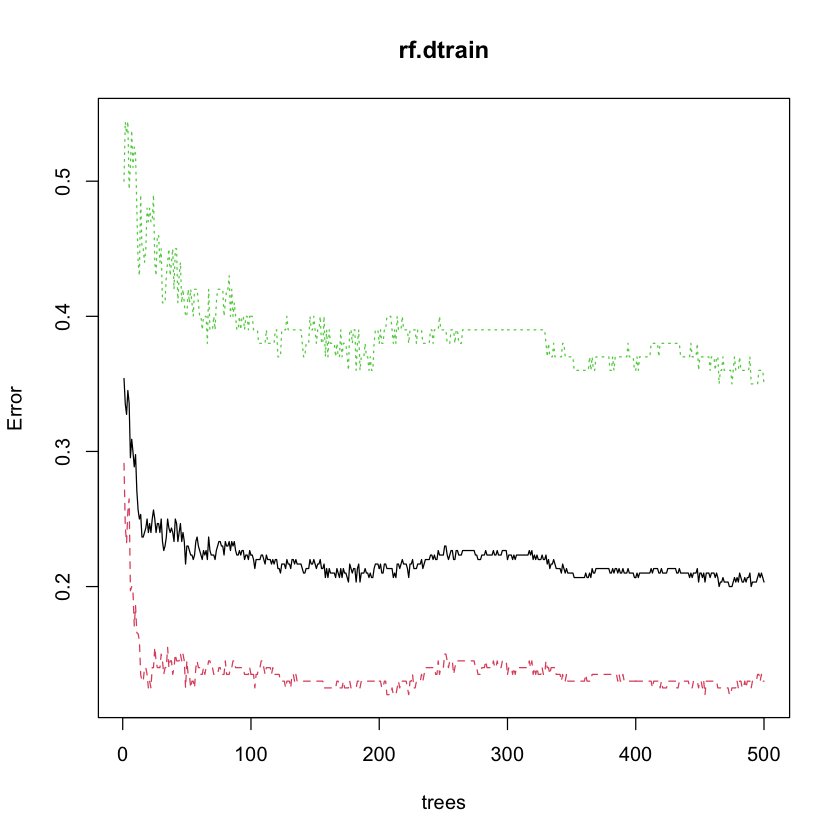

In [23]:
plot(rf.dtrain)
rf.pred = predict(rf.dtrain, newdata=d.test, type='class')
confMat <- table(rf.pred , d.test$diabetes)
confMat
1-sum(diag(confMat))/(sum(confMat[1:2,1:2]))


We can observe that the most important predictors are "glu" and "bmi" as these predictors has the highest mean decrease in Gini index.

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
npreg,9.4800694,0.5483324,8.059594,9.353961
glu,23.2734965,23.2503758,30.469291,38.750832
bp,0.2542303,-2.4043141,-1.607052,10.231970
skin,9.5095034,2.0786439,8.865012,13.772554
bmi,11.9646641,11.1762349,16.844114,23.246248
ped,4.1522007,6.0162413,6.737299,19.655060
age,10.1767300,6.2408120,11.946400,17.853894


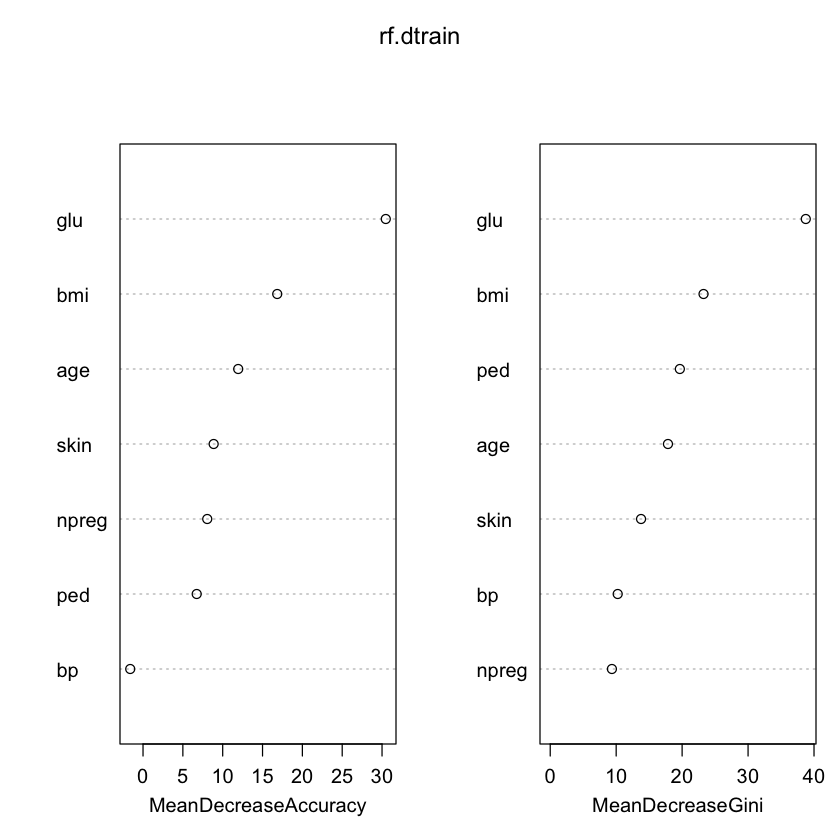

In [24]:
importance(rf.dtrain)
varImpPlot(rf.dtrain)

## 4b)  
# i)
SVM is a better choice when the number of datapoints is small, which it is in this case. SVM with a radial kernel is better than logistic regression when the data is nonlinear. In the case of linear data a SVM with a linear kernel is likely to perform equally to a logistic regression. We can try to use a k-nearest neighbors classifier or Quadratic discriminant analysis as an alternative to SVM.

# ii)
The paper aims to use ensemble SVM-Recursive Feature Elimination (ESVM-RFE) in order to do gene selection. The genes selected from ESVM-RFE was then put through a singular value decomposition, which revealed clusters of similar genes in the dataset. These methods can be used for both dimensionality reduction of the gene data and different classifications of patients based on their genetic information.




# 4 c)

\begin{align*}
    K(X,X') &= K(
    \begin{bmatrix} 
    X_1\\
    X_2
    \end{bmatrix}
    ,
    \begin{bmatrix} 
    X_1'\\
    X_2'
    \end{bmatrix}
    )\\
    &= (1 + X^TX')^2\\
    &= 1 + X_2^2X_2'^2 + 2X_1X_2X_1'X_2' + 2X_2X_2' +2X_1X_1' +X_1'^2X_2'^2\\
    &= \underbrace{\begin{bmatrix} 
    X_1^2 &
    X_2^2 &
    \sqrt{2}X_1X_2 &
    \sqrt{2}X_1 &
    \sqrt{2}X_2 &
    1
    \end{bmatrix}}_{h^T(X)}
    \underbrace{\begin{bmatrix} 
    X_1'^2 \\
    X_2'^2 \\
    \sqrt{2}X_1'X_2' \\
    \sqrt{2}X_1' \\
    \sqrt{2}X_2' \\
    1
    \end{bmatrix}}_{h(X')}\\
    &= \langle h(X'), h(X')  \rangle\\
    h(X) &= \begin{bmatrix} 
    X_1^2 \\
    X_2^2 \\
    \sqrt{2}X_1X_2 \\
    \sqrt{2}X_1\\
    \sqrt{2}X_2 \\
    1
    \end{bmatrix}
\end{align*}

### 5a)  
(i) TRUE  
(ii) FALSE  
(iii) FALSE  
(iv) FALSE  

### 5b)

[1] "red"  "blue" "red"  "red"  "blue" "red" 


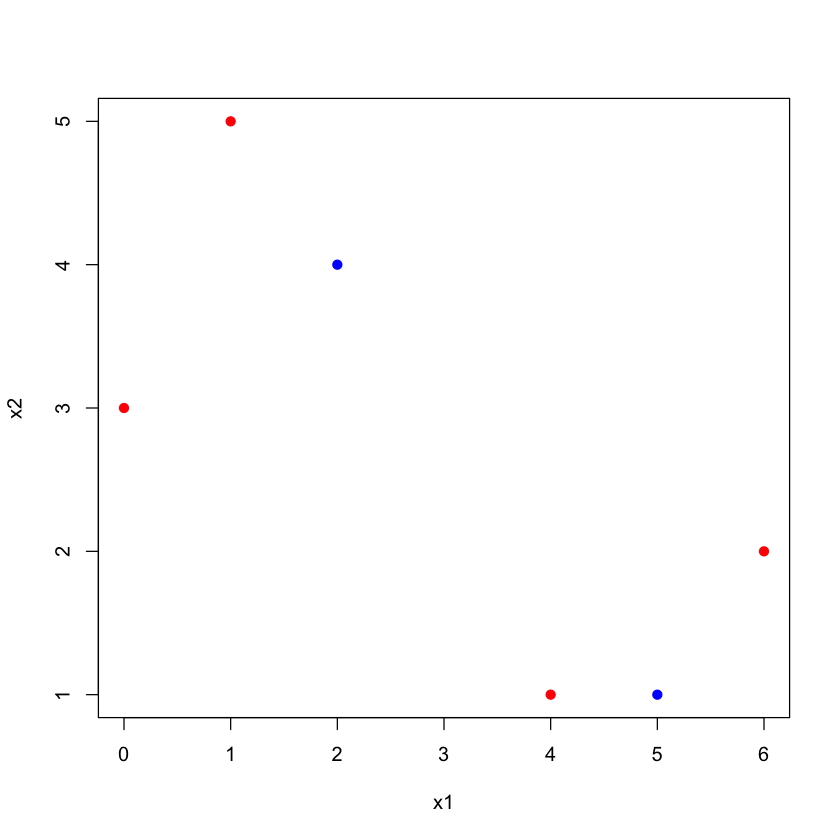

In [25]:
x1 <- c(1, 2, 0, 4, 5, 6)
x2 <- c(5, 4, 3, 1, 1, 2)

set.seed(1)
x_classes <- sample(c("red", "blue"), size=length(x1), replace=TRUE)

print(x_classes)
plot(x1, x2, col=x_classes, pch=19)

In [26]:
# Calculate class centroids
blues1 = c()
blues2 = c()
reds1 = c()
reds2 = c()
for(i in 1:length(x1)) {
    if(x_classes[i] == "red") {
        reds1 = c(reds1, x1[i])
        reds2 = c(reds2, x2[i])
    } else {
        blues1 = c(blues1, x1[i])
        blues2 = c(blues2, x2[i])
    }
}

red_centroid1 = mean(reds1)
red_centroid2 = mean(reds2)
blue_centroid1 = mean(blues1)
blue_centroid2 = mean(blues2)

blue_centroid = c(blue_centroid1, blue_centroid2)
red_centroid = c(red_centroid1, red_centroid2)

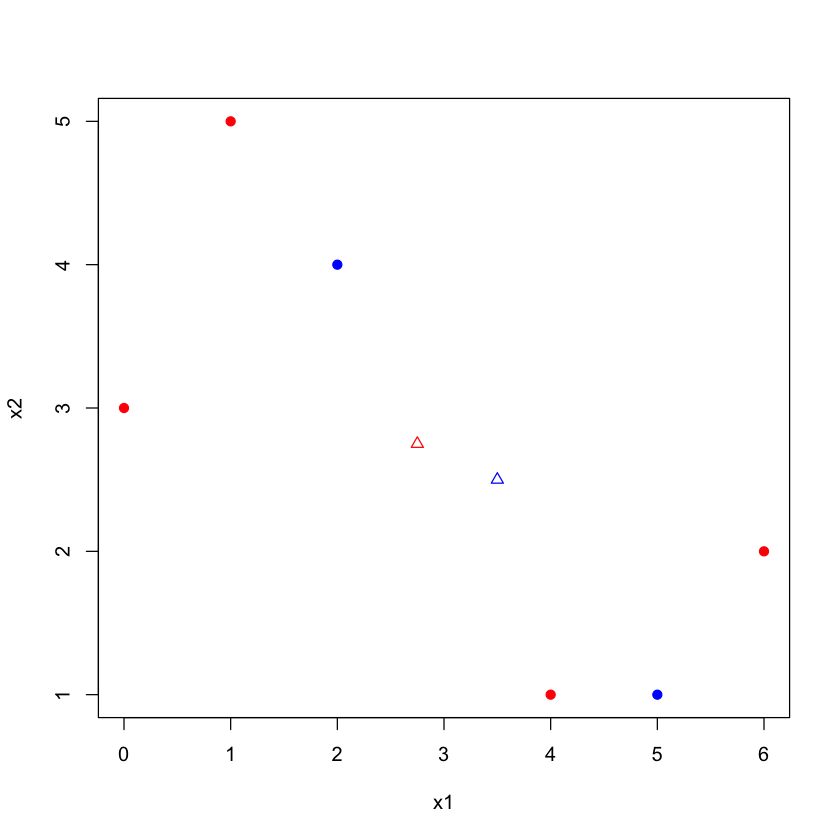

In [27]:
plot(x1, x2, col=x_classes, pch=19)
points(red_centroid1, red_centroid2, col="red", pch=2)
points(blue_centroid1, blue_centroid2, col="blue", pch=2)

In [28]:
euc.dist <- function(x1, x2) sqrt(sum((x1 - x2) ^ 2))

x_classes_new = c()
for(i in 1:length(x1)) {
    this_vec <- c(x1[i], x2[i])
    euc_red = euc.dist(this_vec, red_centroid)
    euc_blue = euc.dist(this_vec, blue_centroid)
    
    if(euc_red < euc_blue) {
        x_classes_new = c(x_classes_new, "red")
    } else {
        x_classes_new = c(x_classes_new, "blue")
    }
}

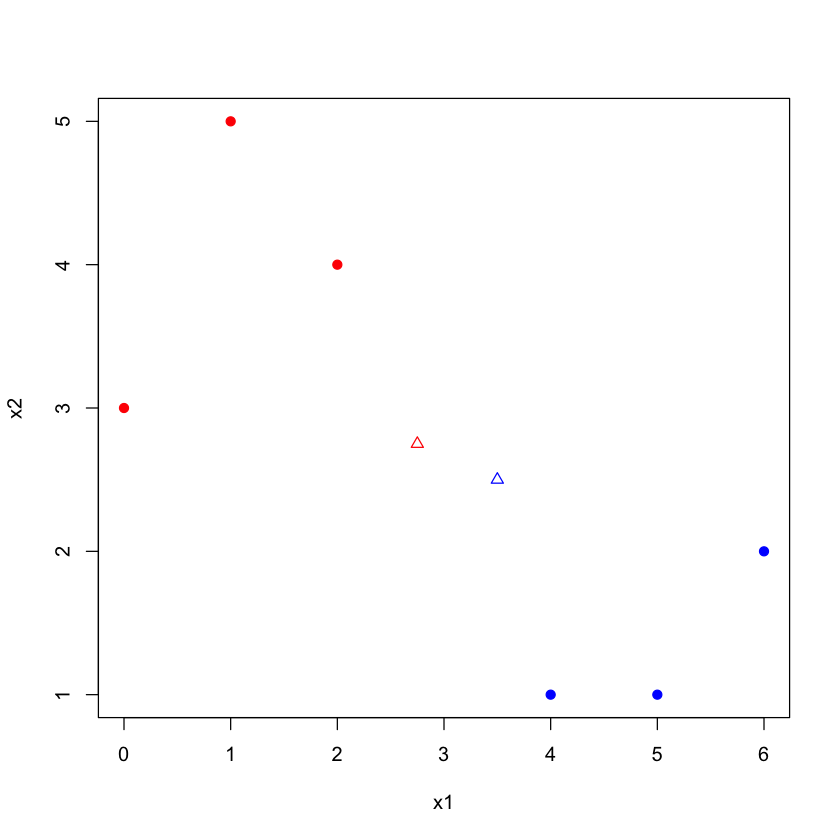

In [29]:
plot(x1, x2, col=x_classes_new, pch=19)
points(red_centroid1, red_centroid2, col="red", pch=2)
points(blue_centroid1, blue_centroid2, col="blue", pch=2)

Notice that classes are all correct now.  

### 5c) + d)  

In [30]:
id <- "1VfVCQvWt121UN39NXZ4aR9Dmsbj-p9OU" # google file ID
GeneData <- read.csv(sprintf("https://docs.google.com/uc?id=%s&export=download", id),header=F)
colnames(GeneData)[1:20] = paste(rep("H", 20), c(1:20), sep = "")
colnames(GeneData)[21:40] = paste(rep("D", 20), c(1:20), sep = "")
row.names(GeneData) = paste(rep("G", 1000), c(1:1000), sep = "")
GeneData = t(GeneData)
GeneData <- scale(GeneData)

 H1  H2  H3  H4  H5  H6  H7  H8  H9 H10 H11 H12 H13 H14 H15 H16 H17 H18 H19 H20 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
 D1  D2  D3  D4  D5  D6  D7  D8  D9 D10 D11 D12 D13 D14 D15 D16 D17 D18 D19 D20 
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 
[1] ""
 H1  H2  H3  H4  H5  H6  H7  H8  H9 H10 H11 H12 H13 H14 H15 H16 H17 H18 H19 H20 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
 D1  D2  D3  D4  D5  D6  D7  D8  D9 D10 D11 D12 D13 D14 D15 D16 D17 D18 D19 D20 
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 
[1] ""
 H1  H2  H3  H4  H5  H6  H7  H8  H9 H10 H11 H12 H13 H14 H15 H16 H17 H18 H19 H20 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
 D1  D2  D3  D4  D5  D6  D7  D8  D9 D10 D11 D12 D13 D14 D15 D16 D17 D18 D19 D20 
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 
[1] ""
 H1  H2

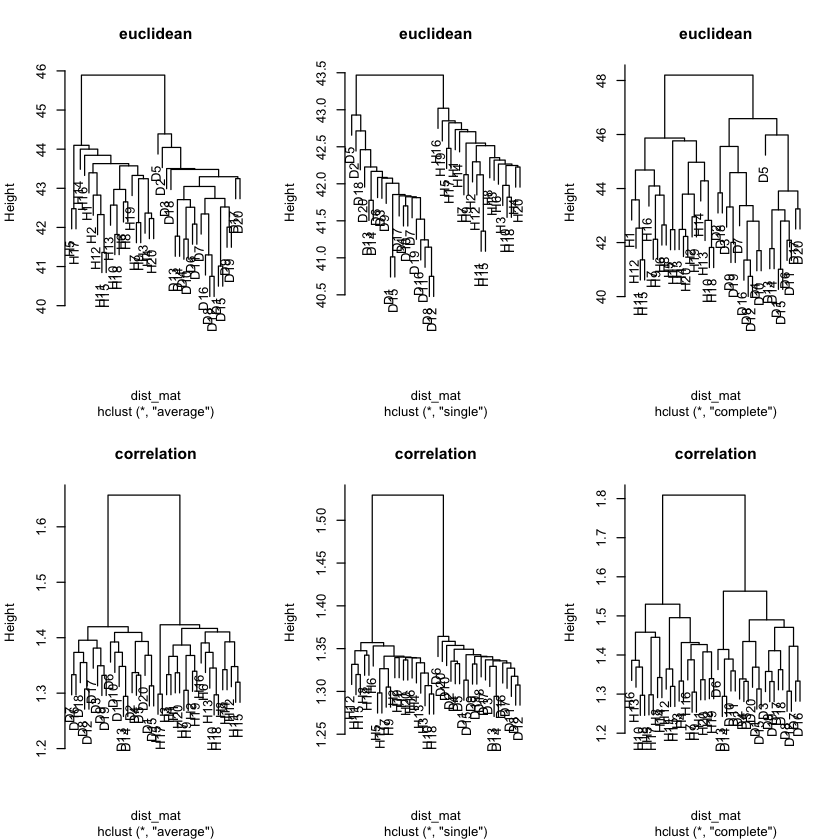

In [31]:
df_sc <- as.data.frame(GeneData)

methods <- c("average", "single", "complete")
dist_types <- c("euclidean", "correlation")

par(mfrow = c(2, 3))
for(j in 1:length(dist_types)) {
    if(dist_types[j] == "correlation") {
        dist_mat <- dist(cor(t(df_sc)))
    } else {
        dist_mat <- dist(df_sc, method = "euclidean")
    }
    for(i in 1:length(methods)) {
        hclust_avg <- hclust(dist_mat, method = methods[i])
        plot(hclust_avg, main = dist_types[j])
        # 5d)
        print(cutree(hclust_avg, 2))
        print("")
    }
}

All distances and linkage types result in dendrograms that are able to split the classes perfectly.

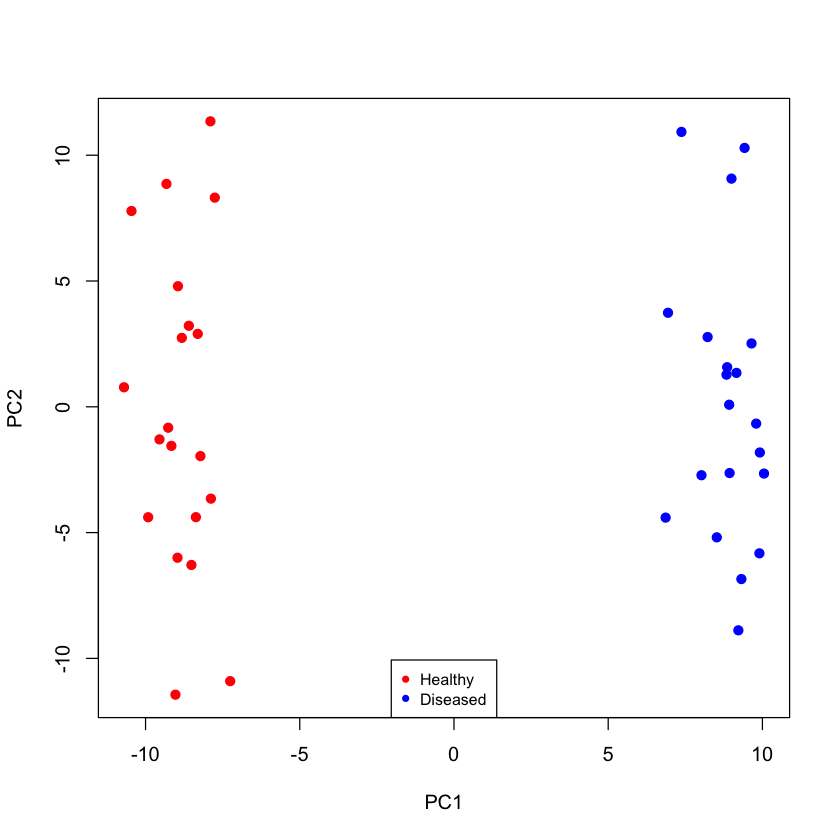

In [32]:
cols <- c(rep(1, 20), rep(2, 20))

pca = prcomp(GeneData, scale = TRUE)
plot(pca$x[, 1:2], col = c("red", "blue")[cols], pch = 19)
legend("bottom", legend = c("Healthy", "Diseased"),
       col = c("red", "blue"), cex = 0.8, pch = 16)

[1] 21.09659


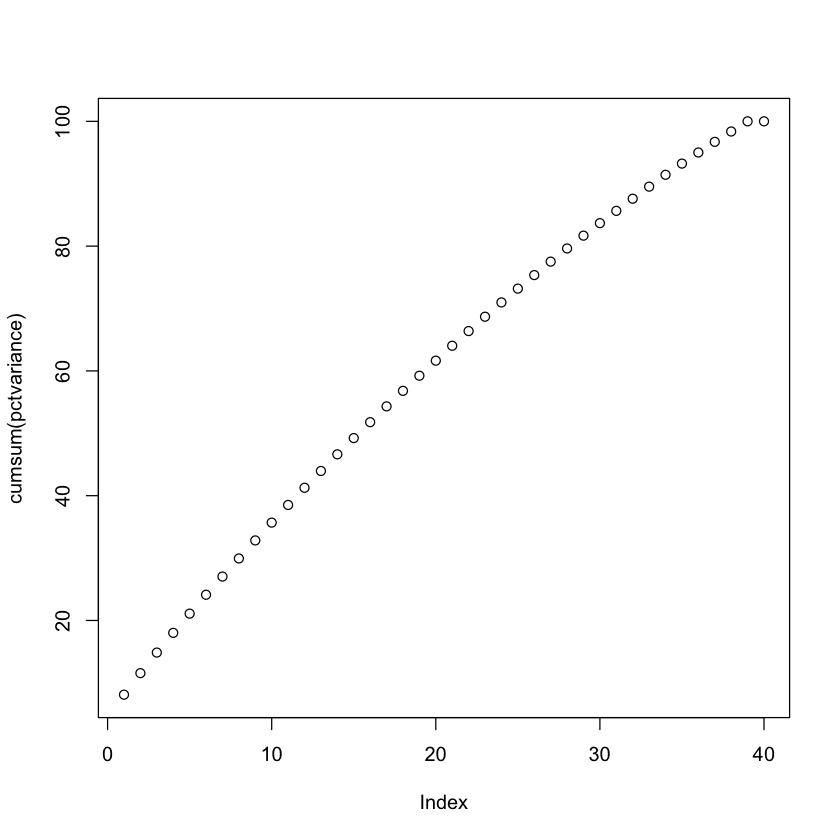

In [33]:
pctvariance <- 100 * pca$sdev^2 / sum(pca$sdev^2)
print(cumsum(pctvariance)[5]) # Variance explained in the first five principal components

plot(cumsum(pctvariance)) # Not good

In [34]:
variations = pca$rotation[, 1]
sort(abs(variations), decreasing = TRUE)[1:5]

G502       G589       G565       G590       G600 
0.09485044 0.09449766 0.09183823 0.09173169 0.09167322